# Ideal Gas

In this notebook, we create a GP model for the temperature-dependence of the average position of a 1D ideal gas in an external field. The system is described in [this paper](https://doi.org/10.1063/5.0014282), and is available as a helpful test module in `thermoextrap` with GP and active-learning specific features defined in `thermoextrap.gpr_active.ig_active`.

In [1]:
import numpy as np
from scipy import linalg

import thermoextrap
from thermoextrap import idealgas

import gpflow

from thermoextrap.gpr_active import ig_active
from thermoextrap.gpr_active import active_utils
from thermoextrap.gpr_active import gp_models

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
gpflow.__version__

'2.5.2'

## Creating a GP model

To start, we need to create some data. We will create data for this analytically tractable system at $\beta = \frac{1}{k_\mathrm{B}T}$ values of 0.1 (high temperature) and 9.6 (low temperature). We do this in two steps: first, we create `IG_DataWrapper` class objects, then we use the associated `get_data()` function of these objects to generate data. All `DataWrapper` objects must be able to generate new data to be useful for active learning. Since we will be comparing to methods like interpolation, and want all models to use the same data, it is important to have the separate data list here.

In [3]:
# Define beta values
beta_list = [0.1, 9.6]

# Create DataWrapper objects that can also be used to build states
wrap_list = [ig_active.IG_DataWrapper(b, seed=None) for b in beta_list]

# Create actual data so consistent when build states with different orders
data_list = [wrap.get_data() for wrap in wrap_list]

Next, we will require `State` objects for creating our GP model. We make sure that each `IG_DataWrapper` object uses the previously generated data when creating a state rather than using new data, and we set the maximum derivative order to 3.

In [4]:
state_list = [
    wrap.build_state(all_data=dat, max_order=1)
    for (wrap, dat) in zip(wrap_list, data_list)
]

The quickest and easiest way to create a GP model from a list of states is to call `create_GPR` in `active_utils`.

In [5]:
gp_model = active_utils.create_GPR(state_list)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Metal device set to: Apple M2


The above creates a GPR model using the default RBF kernel and other default settings, then trains it, again with the default initial values, etc. To get a better sense of what is happening, we will break down the specific information needed to train a GP model and show how to change some default values. As a convenience, most of these can be changed through keyword arguments to `create_GPR`, in particular the `base_kwargs` argument is a dictionary of arguments passed on to the `create_base_GP_model` function we will discuss below.

Essential to a GP model are the input locations, here $\beta$ values, output values (average ideal gas particle positions and derivatives of this with respect to $\beta$), and the noise covariance matrix (covariance matrix at each $\beta$ for values and derivatives). The function `active_utils.input_GP_from_state` is helpful for generating this data from a given `State` object.

In [6]:
x_data = []
y_data = []
cov_data = []

for s in state_list:
    this_x_data, this_y_data, this_cov_data = active_utils.input_GP_from_state(s)
    x_data.append(this_x_data)
    y_data.append(this_y_data)
    cov_data.append(this_cov_data)

Some manipulation is required to properly format this data, in particular making sure that the covariance matrix is block diagonal. In other words, we expect that the calculated values and derivatives at different temperatures are from indpependent simulations and therefore should have zero covariance - at least from the associated noise. We will, of course, employ a kernel with adjustable parameters that learns covariances between different temperatures as part of our GP model. At the same temperature, however, average values and derivatives will clearly have some noise covariance associated with the specific random sample drawn.

In [7]:
x_data = np.vstack(x_data)
y_data = np.vstack(y_data)
noise_cov_mat = linalg.block_diag(*[dat[0, ...] for dat in cov_data])

We can see that the location data (`x_data`) includes the $\beta$ values, but also the associated derivative order.

In [8]:
print(x_data)

[[0.1 0. ]
 [0.1 1. ]
 [9.6 0. ]
 [9.6 1. ]]


The output data (`y_data`) includes the average particle position or derivative at each temperature. So from the `x_data`, we an see that the 3rd entry in the `y_data` list is the 2nd derivative at $\beta=0.1$.

In [9]:
print(y_data)

[[ 0.49158797]
 [-0.08323265]
 [ 0.10408915]
 [-0.01060673]]


As mentioned earlier, the covariance matrix is block-diagonal in structure with the $i^\mathrm{th}$ entry in `x_data` corresponding to the $i\mathrm{th}$ row or column in `noise_cov_mat`.

In [10]:
print(noise_cov_mat)

[[ 8.37603984e-09 -2.19201971e-08  0.00000000e+00  0.00000000e+00]
 [-2.19201971e-08  1.28356006e-06  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.95237242e-10 -7.64728604e-10]
 [ 0.00000000e+00  0.00000000e+00 -7.64728604e-10  2.31726047e-08]]


These these inputs, as a tuple or list, are the required input to `active_utils.create_base_GP_model`. A number of keyword arguments allow adjustment of the model further.

A specific kernel satisfying the `DerivativeKernel` class can be specified, with the default being the RBF kernel.

A mean function can be provided, which should be a callable that takes input locations and produces mean function values. By default, a constant mean function set to the average of the zeroth-order output is used if there are two data points, while more data points are fit to a linear mean function, again fit to the zeroth-order data.

Keyword arguments to the likelihood model can also be specified. The likelihood model used by the `HeteroscedasticGPR` class, which is the output of `active_utils.create_base_GP_model`, is described in detail in the manuscript. Briefly, we model the logarithm of each entry in the covariance matrix as $\ln \Sigma_{\mathrm{n}, i, j} = \ln \Sigma_{\mathrm{n, raw}, i, j} + p (d_i + d_j + 2) + s$, where $\Sigma_\mathrm{n, raw}$ is the raw input noise covariance matrix, $d_i$ is the derivative order of data point $i$, and $p$ and $s$ are tunable parameters. Allow the noise do be scaled by a constant or scaled according to the derivative order to account for inaccurate uncertainty estimates. This is most useful in the case that some derivative orders are much more uncertain than others, with the accuracy of the uncertainty estimates changing in a correlated fashion. This is typical with increasing derivative order for molecular simulation data, so by default $p>0$ but able to be optimized and $s=0$. In what is below, however, we also constrain $p$ to be zero to only look at the behavior of the kernel without considering the likelihood model, which allows better comparisons of different kernels and makes GPR more comparable to polynomial interpolation (we will do these things shortly).

In [11]:
this_gp = active_utils.create_base_GP_model(
    (x_data, y_data, noise_cov_mat),
    kernel=active_utils.RBFDerivKernel,
    mean_func=None,
    likelihood_kwargs={"p": 0.0, "transform_p": None, "constrain_p": True},
)

We can take a look at our GP model taking advantage of automated printing in a Jupyter notebook:

In [12]:
this_gp

name,class,transform,prior,trainable,shape,dtype,value
HeteroscedasticGPR.kernel.kernel.var,Parameter,Softplus,,True,(),float64,1
HeteroscedasticGPR.kernel.kernel.l,Parameter,Softplus,,True,(),float64,1
HeteroscedasticGPR.likelihood.power_scale,Parameter,Identity,,False,(),float64,0
HeteroscedasticGPR.likelihood.power_add,Parameter,Identity,,False,(),float64,0


Two parameters are adjustable (the kernel variance and length scale) and start with default values of 1, while the other two parameters ($p$ and $s$) are set to zero and not trainable. Note that no training has yet taken place. We now must train the model.

In [13]:
active_utils.train_GPR(this_gp)

And we can examine the model now that it's trained:

In [14]:
this_gp

name,class,transform,prior,trainable,shape,dtype,value
HeteroscedasticGPR.kernel.kernel.var,Parameter,Softplus,,True,(),float64,1.48656
HeteroscedasticGPR.kernel.kernel.l,Parameter,Softplus,,True,(),float64,4.59991
HeteroscedasticGPR.likelihood.power_scale,Parameter,Identity,,False,(),float64,0
HeteroscedasticGPR.likelihood.power_add,Parameter,Identity,,False,(),float64,0


By specifying some $\beta$ values to make predictions at, we can look at the behavior of the GP model. Note that we are making predictions for the zeroth-order derivatives, or the values of the average particle location. We accomplish this by appending a column of zeros to our $\beta$ values, though any derivative order could be predicted, even those not used for training, by appending a different value, or set of values, in this column.

In [15]:
test_betas = np.linspace(beta_list[0], beta_list[-1], 100)

# Make predictions using predict_f (see GPflow)
gp_mu, gp_var = this_gp.predict_f(np.vstack([test_betas, np.zeros_like(test_betas)]).T)

All predictions will be Tensorflow `Tensor` objects, so it's a bit easier for plotting to convert to numpy arrays. Further, we want to plot 95\% confidence intervals.

In [16]:
gp_mu = gp_mu.numpy()
gp_std = np.sqrt(gp_var.numpy())
gp_qs = np.concatenate([gp_mu - 2.0 * gp_std, gp_mu + 2.0 * gp_std], axis=1)

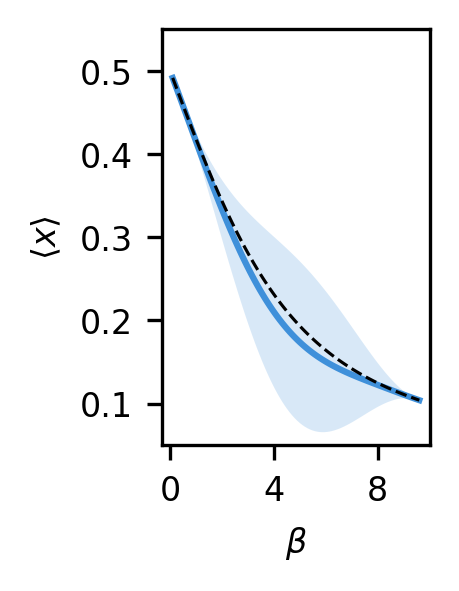

In [17]:
fig, ax = plt.subplots(figsize=(1.15, 1.8), dpi=300)

ax.plot(test_betas, gp_mu, label="GPR, RBF")
ax.fill_between(test_betas, gp_qs[:, 0], gp_qs[:, 1], alpha=0.2)

ax.plot(test_betas, idealgas.x_ave(test_betas), "k--", linewidth=0.75)

ax.xaxis.set_major_locator(MaxNLocator(prune="both", nbins=3))
ax.tick_params(axis="both", labelsize=8)

ax.set_ylabel(r"$\langle x \rangle$", fontsize=8)
ax.set_xlabel(r"$\beta$", fontsize=8)

ax.set_xlim((-0.3, 10.0))
ax.set_ylim((0.05, 0.55))

plt.show()

## Compare kernels and polynomial interpolation

There are two key differences to take not of when comparing GPR to polynomial interpolation:
  1. No specific functional form is assumed. With polynomial interpolation, you assume (at first derivative order) that a 3rd order polynomial is the exactly correct functional form and compute uncertainty within that assumption. A GP model with an RBF kernel is a universal function approximator, so no specific form is assumed, other than the idea that the function should be smooth on an inferred lengthscale. This leads to greater uncertainty with lower order derivatives because the model is not restricted to any specific order polynomial at any order.
  2. Uncertainties are taken into account when fitting the model. Polynomial interpolation does not weight input data, such as different orders of derivatives, by their uncertainty when using that data for model fitting. GP models can be used for polynomial interpolation and weight information by its uncertainty by using a polynomial kernel. Using an RBF kernel, however, takes us a step further and saves us from needing to select a specific polynomial order, and is infinitely differentiable. Due to its weighting of provided training information by uncertainty, a GP can utilize much higher derivative order information, even becoming more certain in its model fit with high derivative order data.

To examine these differences, we plot, as in Figure 1 of the paper, the results for GPR and polynomial interpolation using only zeroth, first, and third order derivative information. The code here is long because we want to use the same `State` objects, and thus the exact same data, for all models at every order.

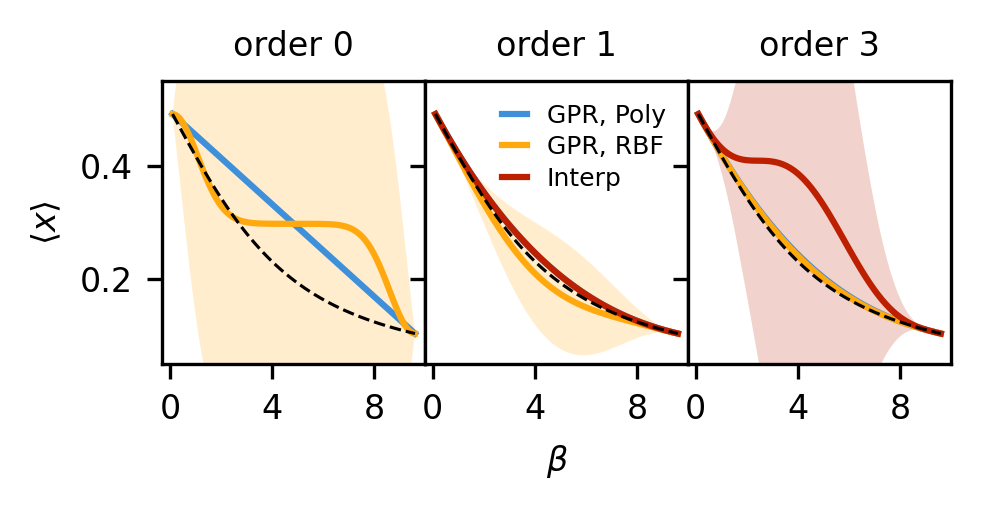

In [18]:
# Plot the results of making predictions with each model
# Idea is to go to higher order and look at effects
d_orders = [0, 1, 3]

test_betas = np.linspace(beta_list[0], beta_list[-1], 100)

fig, ax = plt.subplots(
    1, len(d_orders), sharex=True, sharey=True, figsize=(3.37, 1.8), dpi=300
)

for i, d_o in enumerate(d_orders):
    if d_o == 0:
        m_order = 1
    else:
        m_order = d_o

    # And create states (ExtrapModel objects), using up to max_order derivative orders
    # Order will define what order is used in GP models as well
    this_states = [
        wrap.build_state(all_data=dat, max_order=m_order)
        for (wrap, dat) in zip(wrap_list, data_list)
    ]

    # Create interpolating model
    this_interp = thermoextrap.InterpModel(this_states)

    # Will create two different types of GP models, with different kernel for each
    x_data = []
    y_data = []
    cov_data = []
    for s in this_states:
        this_x_data, this_y_data, this_cov_data = active_utils.input_GP_from_state(s)
        x_data.append(this_x_data)
        y_data.append(this_y_data)
        cov_data.append(this_cov_data)

    x_data = np.vstack(x_data)
    y_data = np.vstack(y_data)
    noise_cov_mat = linalg.block_diag(*[dat[0, ...] for dat in cov_data])

    if d_o == 0:
        x_data = x_data[::2, :]
        y_data = y_data[::2, :]
        noise_cov_mat = noise_cov_mat[::2, ::2]

    data_input = (x_data, y_data, noise_cov_mat)

    # For purposes of comparing models and comparing to interpolation, best to fix likelihood behavior
    # In other words, don't want to scale variances based on derivative order here
    # Essentially saying that here we trust our uncertainty estimates, so no learning of likelihood params
    # And no modification of covariance matrix
    like_kws = {"p": 0.0, "transform_p": None, "constrain_p": True}

    # Create GP model with default RBF kernel
    this_gp = active_utils.create_base_GP_model(
        data_input,
        likelihood_kwargs=like_kws,
    )
    active_utils.train_GPR(this_gp)

    # And a GP model with a polynomial kernel of order high enough for current derivative order usage
    # Will match order used by interpolation, but will weight uncertainties in Bayesian framework
    poly_kern_info = active_utils.make_poly_expr(2 * d_o + 1)
    poly_kern = gp_models.DerivativeKernel(
        poly_kern_info[0], 1, kernel_params=poly_kern_info[1]
    )
    this_gp_poly = active_utils.create_base_GP_model(
        data_input,
        kernel=poly_kern,
        likelihood_kwargs=like_kws,
    )
    active_utils.train_GPR(this_gp_poly)

    interp_mu = this_interp.predict(test_betas).values
    interp_resamples = this_interp.resample(nrep=1000).predict(test_betas)
    interp_qs = interp_resamples.quantile([0.05, 0.95], dim="rep").values

    gp_mu, gp_var = this_gp.predict_f(
        np.vstack([test_betas, np.zeros_like(test_betas)]).T
    )
    gp_mu = gp_mu.numpy()
    gp_std = np.sqrt(gp_var.numpy())
    gp_qs = np.concatenate([gp_mu - 2.0 * gp_std, gp_mu + 2.0 * gp_std], axis=1)

    gppoly_mu, gppoly_var = this_gp_poly.predict_f(
        np.vstack([test_betas, np.zeros_like(test_betas)]).T
    )
    gppoly_mu = gppoly_mu.numpy()
    gppoly_std = np.sqrt(gppoly_var.numpy())
    gppoly_qs = np.concatenate(
        [gppoly_mu - 2.0 * gppoly_std, gppoly_mu + 2.0 * gppoly_std], axis=1
    )

    ax[i].plot(test_betas, gppoly_mu, label="GPR, Poly")
    ax[i].fill_between(test_betas, gppoly_qs[:, 0], gppoly_qs[:, 1], alpha=0.2)

    ax[i].plot(test_betas, gp_mu, label="GPR, RBF")
    ax[i].fill_between(test_betas, gp_qs[:, 0], gp_qs[:, 1], alpha=0.2)

    if d_o > 0:
        ax[i].plot(test_betas, interp_mu, label="Interp")
        ax[i].fill_between(
            test_betas, interp_qs[0, :, 0], interp_qs[1, :, 0], alpha=0.2
        )

    ax[i].plot(test_betas, idealgas.x_ave(test_betas), "k--", linewidth=0.75)

    ax[i].set_title(r"order %i" % d_o, fontsize=8)
    ax[i].xaxis.set_major_locator(MaxNLocator(prune="both", nbins=3))
    ax[i].tick_params(axis="both", labelsize=8)

ax[0].set_ylabel(r"$\langle x \rangle$", fontsize=8)
ax[1].set_xlabel(r"$\beta$", fontsize=8)

ax[0].set_xlim((-0.3, 10.0))
ax[0].set_ylim((0.05, 0.55))

ax[1].legend(frameon=False, handlelength=1.0, fontsize=6, labelspacing=0.3)

fig.tight_layout()
fig.subplots_adjust(wspace=0.0)

plt.show()

## Demonstration of active learning

A brief demonstration of active learning is now shown, with two different active learning strategies. In both, we will two separate stopping criteria that must both satisfy their respective tolerances simultaneously. These will be the maximum relative variance predicted by the GP model ($\mathrm{max}(\mathbf{\sigma}_{rel})$ in the paper and `MaxRelGlobalVar` in the code) and the maximum relative deviation since the last update ($\mathrm{max}(\mathbf{\delta}_{iter})$ in the paper and `MaxAbsRelGlobalDeviation` in the code). You need both because the first can become very small if the model becomes prematurely certain of itself - you'll see a jump on the next iteration if this is the case. The second only becomes small when adding new points stops modifiying the function, but you also need the maximum relative variance criteria so that the uncertainty is ensured to reach a specified target. Otherwise, you could have the GP model not changing while the uncertainty remains high.

### ALM (Maximum variance)

We start with updates that select new points based on where the GP model predicts the highest variance. The below code sets up and executes an active learning run. As we go, plots of the progress will be shown and compared to the, in this case known, ground truth.



Initial beta values:  [0.1, 9.6]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.48641    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.59952    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticGPR.likelihood.power_scale

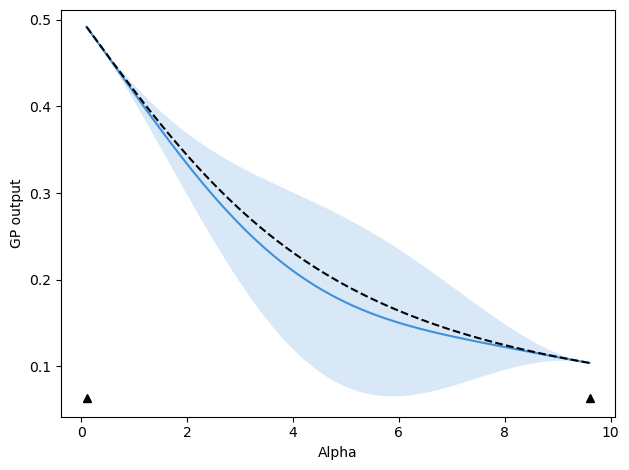


After 1 updates, beta values are: 
[0.1, 9.6, 4.845245245245246]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 6.85509     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.91396     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ Het

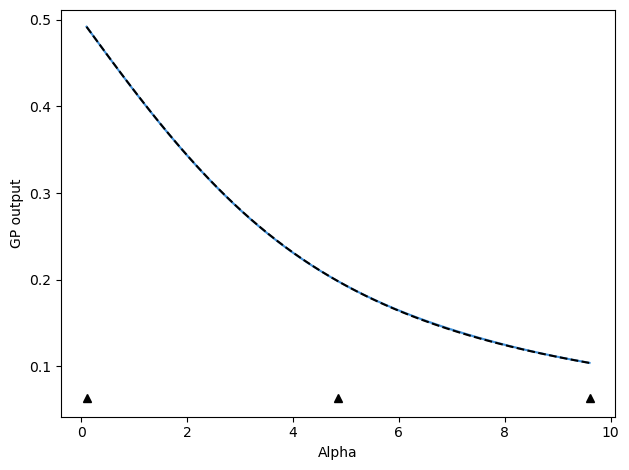


After 2 updates, beta values are: 
[0.1, 9.6, 4.845245245245246, 2.0684684684684687]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 3.55717     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 3.80006     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼

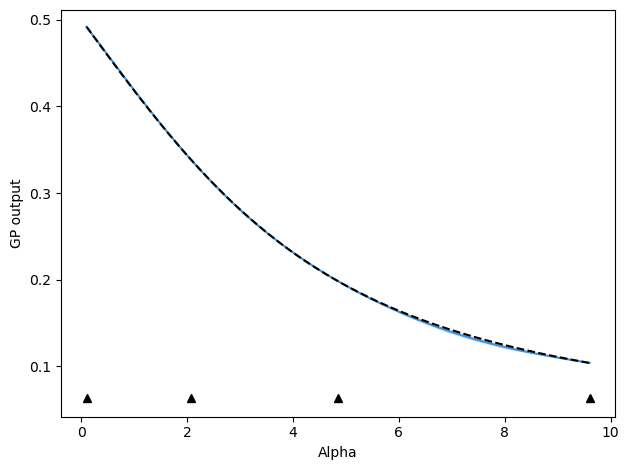


After 3 updates, beta values are: 
[0.1, 9.6, 4.845245245245246, 2.0684684684684687, 7.251151151151151]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 8.55103  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.80266  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────

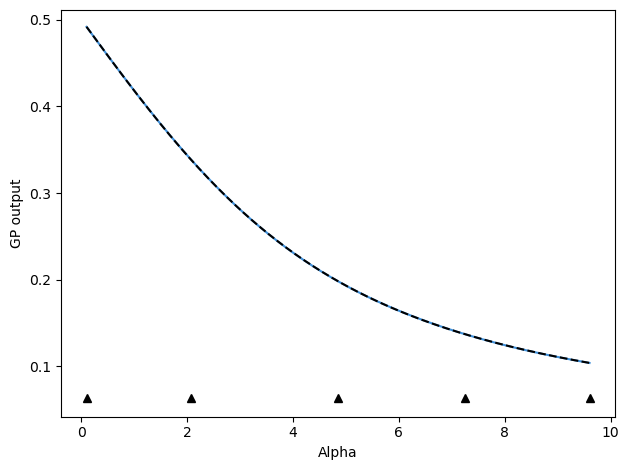


After 4 updates, beta values are: 
[0.1, 9.6, 4.845245245245246, 2.0684684684684687, 7.251151151151151, 0.8702702702702703]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 9.47951  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.84643  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────

In [19]:
# Define beta values to start and find function between
beta_list = [0.1, 9.6]

# Set up active learning protocol
deriv_order = 1
sim_protocol = ig_active.SimulateIG()

# Update by selecting point with maximum variance (uncertainty) predicted by model
update_func = active_utils.UpdateALMbrute(
    show_plot=True,
    compare_func=idealgas.x_ave,
)

# Metrics for stopping criteria with tolerances of 0.01
metrics = [
    active_utils.MaxRelGlobalVar(1e-02),
    active_utils.MaxAbsRelGlobalDeviation(1e-02),
]

# Define stopping criteria (will have to satisfy all metrics reaching tolerances)
stop_func = active_utils.StopCriteria(metrics)

# Run active learning
active_list, train_history = active_utils.active_learning(
    beta_list,
    sim_protocol,
    update_func,
    stop_criteria=stop_func,
    max_order=deriv_order,
    alpha_name="beta",
)

To plot or examine the results aftwards, we can note that the returned `train_history` dictionary contains quite a bit of pertinent information, especially if we set `save_history=True`, though that will save a .npz file of this dictionary so we do not do it here.

In [20]:
train_history

{'loss': [3.2507510705764253,
  4.91000328731043,
  1.399727354179742,
  -2.4915684880846456,
  -8.328047824694043],
 'params': [[array(4.59952118), array(1.48640622), array(0.00113597)],
  [array(4.91395956), array(6.85508863), array(2.82589304e-06)],
  [array(3.80006472), array(3.55717488), array(2.62155079e-07)],
  [array(4.80265527), array(8.55102948), array(0.36700411)],
  [array(4.84643139), array(9.4795095), array(0.13695855)]],
 'MaxRelGlobalVar': [0.4371759046250532,
  0.008402339332781852,
  0.011398021909848623,
  0.003343668958617897,
  0.001268546362125952],
 'MaxAbsRelGlobalDeviation': [4.411052897156387,
  0.18938427673320804,
  0.027179965607974112,
  0.022727068293967773,
  0.001201886949586077]}

The "loss" is the value of the GPR loss function at each iteration, "params" are the optimal GP parameters (only the trainable ones, so here $p$, $l_\mathrm{K}$, and $\sigma_\mathrm{K}$) at each iteration, then the stopping criteria metrics by name.

Based on this, it is easy to plot our metrics as a function of iterations, for instance.

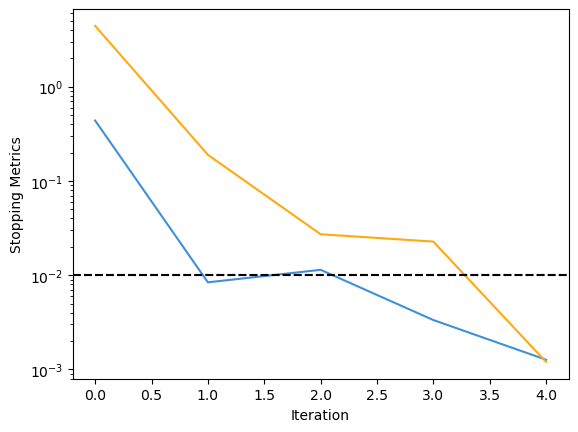

In [21]:
fig, ax = plt.subplots()

ax.plot(train_history["MaxRelGlobalVar"])
ax.plot(train_history["MaxAbsRelGlobalDeviation"])

ax.axhline(y=metrics[0].tol, color="k", linestyle="--")
ax.axhline(y=metrics[1].tol, color="k", linestyle=":")

ax.set_yscale("log")

ax.set_xlabel("Iteration")
ax.set_ylabel("Stopping Metrics")

plt.show()

With `save_history=True`, the GP mean and standard deviation predictions will also be returned. If this is not returned, we can still access these at each iteration through the `StopCriteria` class, which saves a history of these. To plot the function itself, with indications of where we sampled our data from, we can do the following, making use of the fact that the update classes also have a built-in plotting function:

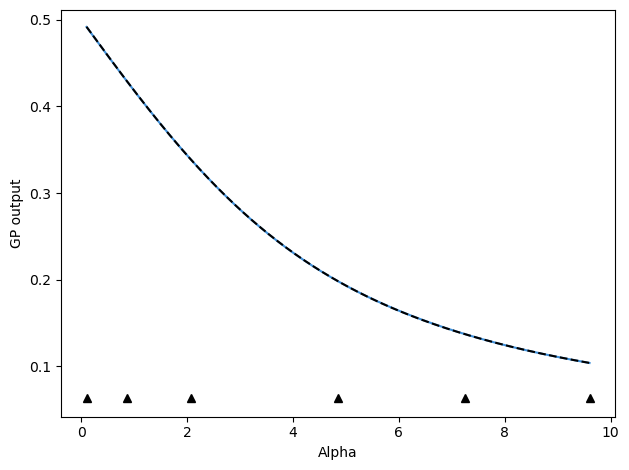

In [22]:
update_func.do_plotting(
    stop_func.create_alpha_grid(beta_list)[0],
    stop_func.history[0][-1, ...],
    [
        stop_func.history[0][-1, ...] - 2.0 * stop_func.history[1][-1, ...],
        stop_func.history[0][-1, ...] + 2.0 * stop_func.history[1][-1, ...],
    ],
    [dat.beta for dat in active_list],
)

### Space-filling

Next, we can also follow an active learning protocol where we select the next point as the point furthest away from any other points already chosen.



Initial beta values:  [0.1, 9.6]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.48756    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.60242    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticGPR.likelihood.power_scale

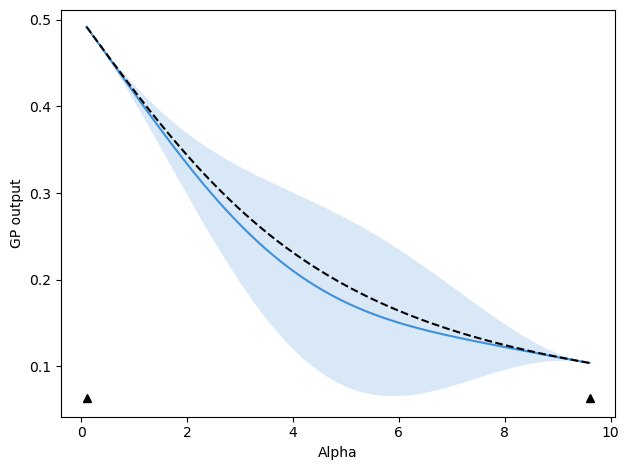


After 1 updates, beta values are: 
[0.1, 9.6, 4.85]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 6.85836     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.91423     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticG

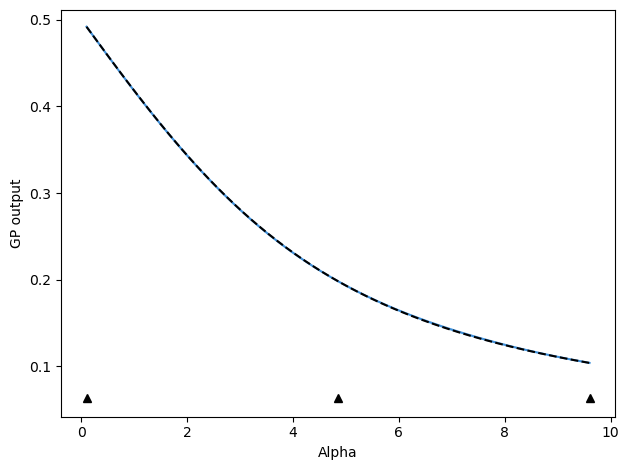


After 2 updates, beta values are: 
[0.1, 9.6, 4.85, 2.475]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 3.39015    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 3.83338    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticG

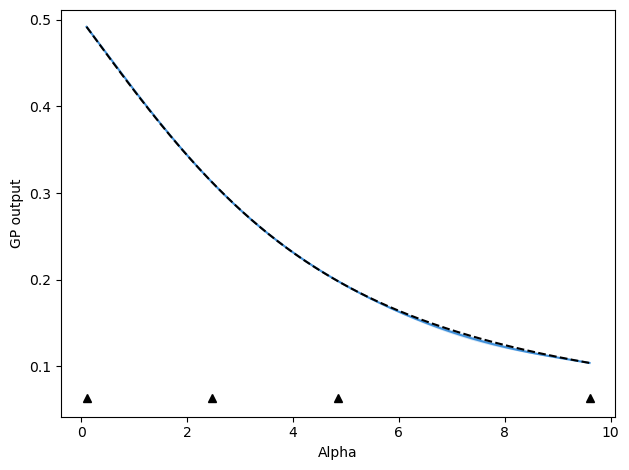


After 3 updates, beta values are: 
[0.1, 9.6, 4.85, 2.475, 7.225]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 8.1504   │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.83504  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.like

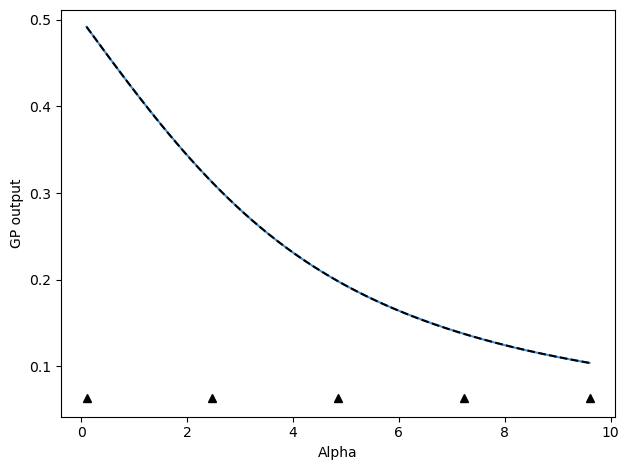


After 4 updates, beta values are: 
[0.1, 9.6, 4.85, 2.475, 7.225, 3.6624999999999996]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 9.84103   │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 5.17591   │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────

In [23]:
# Define beta values to start and find function between
beta_list = [0.1, 9.6]

# Set up active learning protocol
deriv_order = 1
sim_protocol = ig_active.SimulateIG()
# Update by selecting point with maximum variance (uncertainty) predicted by model
update_func_space = active_utils.UpdateSpaceFill(
    show_plot=True,
    compare_func=idealgas.x_ave,
)
metrics = [
    active_utils.MaxRelGlobalVar(1e-02),
    active_utils.MaxAbsRelGlobalDeviation(1e-02),
]
stop_func_space = active_utils.StopCriteria(metrics)

active_list_space, train_history_space = active_utils.active_learning(
    beta_list,
    sim_protocol,
    update_func_space,
    stop_criteria=stop_func_space,
    max_order=deriv_order,
    alpha_name="beta",
)

### Comparison

In this simple system, the maximum-variance and space-filling updates yield nearly the same results. Note, though, that the chosen points are slightly different and that the uncertainties are more uniform for the maximum-variance strategy.

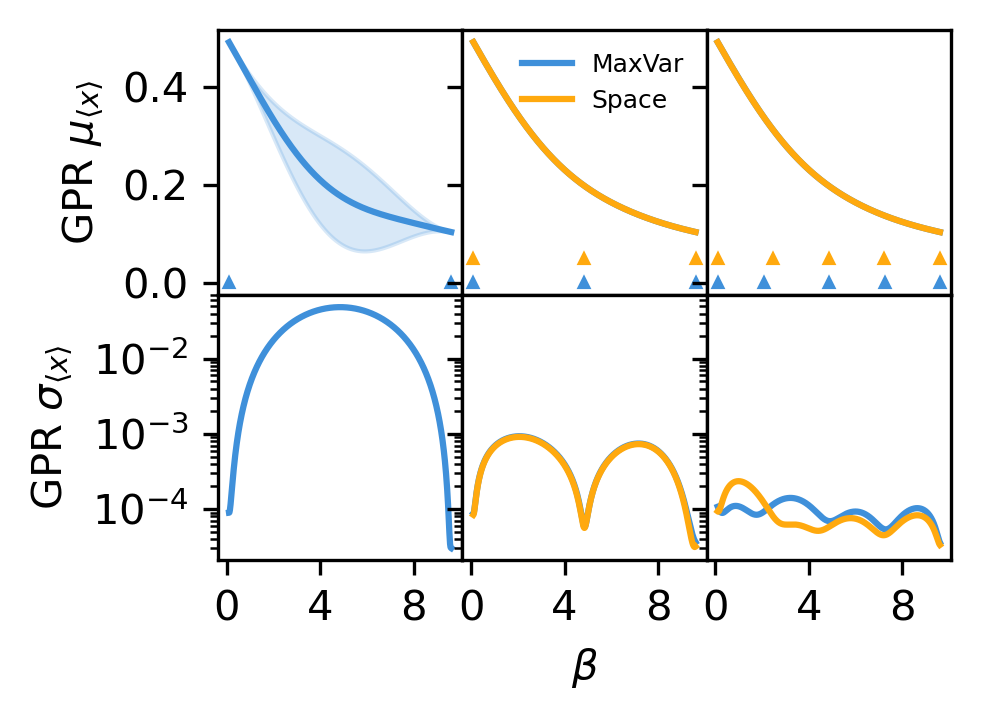

In [24]:
# Or want to plot series of updates to provide sense of how active learning is working
plot_betas = np.linspace(beta_list[0], beta_list[-1], 1000)

update_inds = [0, 1, -1]

fig, ax = plt.subplots(
    2, len(update_inds), sharex=True, sharey="row", figsize=(3.37, 2.5), dpi=300
)

update_colors = ["#3f90da", "#ffa90e"]
update_labels = ["MaxVar", "Space"]

for j, active_info in enumerate(
    zip([stop_func, stop_func_space], [active_list, active_list_space])
):
    this_mu, this_std = active_info[0].history
    this_mu = np.squeeze(this_mu)
    this_std = np.squeeze(this_std)
    this_alpha = np.array([dat.beta for dat in active_info[1]])
    for i, ind in enumerate(update_inds):
        if ind == 0 and j == 1:
            continue
        ax[0, i].plot(
            plot_betas, this_mu[ind, :], color=update_colors[j], label=update_labels[j]
        )
        ax[0, i].fill_between(
            plot_betas,
            this_mu[ind, :] - 2.0 * this_std[ind, :],
            this_mu[ind, :] + 2.0 * this_std[ind, :],
            color=update_colors[j],
            alpha=0.2,
        )
        ax[1, i].plot(
            plot_betas, this_std[ind, :], color=update_colors[j], label=update_labels[j]
        )
        if ind == -1:
            end_ind = -1
        else:
            end_ind = ind + 2
        ax[0, i].plot(
            this_alpha[:end_ind],
            (j * 0.05) * np.ones_like(this_alpha[:end_ind]),
            marker="^",
            markersize=2,
            color=update_colors[j],
            linestyle="",
        )
        ax[0, i].xaxis.set_major_locator(MaxNLocator(prune="both", nbins=3))
        ax[0, i].tick_params(axis="both", labelsize=10)
        ax[1, i].tick_params(axis="both", labelsize=10)

ax[0, 1].legend(frameon=False, fontsize=6)

ax[0, 0].set_ylabel(r"GPR $\mu_{\langle x \rangle}$", fontsize=10)
ax[1, 0].set_ylabel(r"GPR $\sigma_{\langle x \rangle}$", fontsize=10)
ax[1, 1].set_xlabel(r"$\beta$", fontsize=10)

ax[1, 0].set_yscale("log")

fig.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

plt.show()